## Exercise

In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. 

### Movie ratings dataset

The dataset is in the file `ex8_movies.mat` and it provides the variables `Y` and `r`.
The matrix `Y` (a `num_movies` $\times$ `num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix `r` is a binary-valued indicator matrix, where $r(i, j) = 1$ if user $j$ gave a rating to movie $i$ and $R(i, j) = 0$ otherwise.

#### Importing libraries

In [1]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot as plt
import matplotlib as mpl

# Optimization module in scipy
from scipy import optimize

# Will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# tells matplotlib to embed plots within the notebook
%matplotlib inline

#### Load and visualize data

I will start by loading the data and visualize it using .imshow method of matplotlib. The color scheme gives an idea of all the ratings that are in the dataset.

Average rating for movie 1 (Toy Story): 3.88


Text(0.5, 0, 'Users')

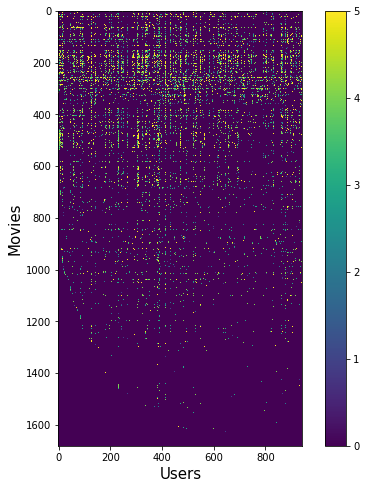

In [2]:
# Load data
data = loadmat('Data/ex8_movies.mat')
Y = data['Y'] # Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 943 users
r = data['R'] # r is a 1682x943 matrix, where r(i,j) = 1 if user j gave a rating to movie i or r(i,j) = 0 otherwise

# From the Y matrix, I can compute statistics like the average rating of a movie
print(f'Average rating for movie 1 (Toy Story): {round(np.mean(Y[0, r[0, :] == 1]), 2)}')

# I can "visualize" the ratings matrix by plotting it with imshow
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies', fontsize=15)
plt.xlabel('Users', fontsize=15)

### Collaborative filtering algorithm

The objective of collaborative filtering in the setting of movie recommendations is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $r(i, j) = 0$. This will allow me to recommend the movies with the highest predicted ratings to the user. The learned model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left( \theta^{(j)} \right)^T x^{(i)}$.

To do this, I will learn the features $x$ and the parameters $\theta$ that produce the best fit (minimize the squared error):

$$ \text{x} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

The $i^{th}$ row of $x$ corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie and the $j^{th}$ row of $\theta$ corresponds to the parameter vector $\theta^{(j)}$ for the $j^{th}$ user. For the purposes of this exercise, I will use $n = 100$ and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$. Correspondingly, $x$ is a $n_m \times 100$ matrix and $\theta$ is a $n_u \times 100$ matrix.

#### Cost function and gradient

The collaborative filtering cost function with regularization is defined as:

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

The gradients for the regularized cost function are defined as:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)} $$

To start implementing the collaborative filtering algorithm, I will compute the cost function and the gradient for $x$ and $\theta$ using regularization in the function `costFunction`.

**Note 1:** To use advanced optimization algorithms to learn the parameters, I need to unroll the parameters $x$ and $\theta$ into one vector so they can be used in the `optimize.minimize` method of Scipy. Inside the `costFunction` I reshape the parameters vector into the original matrices $x$ and $\theta$.

**Note 2:** I should accumulate the cost and gradient for user $j$ and movie $i$ only if `r[i,j] = 1`.

In [3]:
def costFunction(parameters, Y, r, num_users, num_movies, num_features, lambda_=0.0):
    # Reshape parameters matrix back into the parameters x and Theta
    x = parameters[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = parameters[num_movies * num_features:].reshape(num_users, num_features)

    # Cost function
    J = (1 / 2) * np.sum((x.dot(Theta.T) - Y)**2 * r) + (lambda_ / 2) * np.sum(Theta**2) + (lambda_ / 2) * np.sum(x**2)
    
    # Gradients
    x_grad = ((x.dot(Theta.T) - Y) * r).dot(Theta) + lambda_ * x
    Theta_grad = ((x.dot(Theta.T) - Y) * r).T.dot(x) + lambda_ * Theta
    
    # # Unroll parameters into vector
    grad = np.concatenate([x_grad.ravel(), Theta_grad.ravel()])
    
    return J, grad

#### Gradient checking

To make sure that the computation of the gradients using collaborative filtering is correct, I will use gradient checking. In the folder `Data` I am given a dataset with learned parameters $x$ and $\theta$ that I can use to run gradient checking. 

If the difference between the numerical estimate of the gradients and the gradients using collaborative filtering is less than 1e-9 then my cost function implementation is correct.

In [4]:
def gradientChecking(parameters, Y, r, num_users, num_movies, num_features, lambda_=0.0):
    # Labels of printed columns
    print('Numerical gradient \t Collaborative filtering gradient \t\t Difference')
    
    # Set epsilon and initialize epsilon perturbation vector
    epsilon = 0.0001
    num_parameters = len(parameters)
    epsilon_vector = np.zeros(num_parameters)
    
    # Computed gradient from collaborative filtering
    _, gradient = costFunction(parameters, Y, r, num_users, num_movies, num_features, lambda_)

    # Choose 10 random elements of the parameters vector, compute the numerical gradient for each and
    # compute the difference between both gradients for these 10 elements
    for i in range(10):
        idx = np.random.randint(0, num_parameters)
        epsilon_vector[idx] = epsilon # Add epsilon value to selected index of epsilon perturbation vector
        
        # Numerical gradient
        loss1, _ = costFunction(parameters - epsilon_vector, Y, r, num_users, num_movies, num_features, lambda_)
        loss2, _ = costFunction(parameters + epsilon_vector, Y, r, num_users, num_movies, num_features, lambda_)
        numerical_gradient = (loss2 - loss1) / (2 * epsilon)
        
        # Set the changed value in epsilon perturbation vector back to 0 so that the vector can be used again 
        # in the next iteration for another index
        epsilon_vector[idx] = 0
        
        # Print computed values for the gradients and the difference between them
        print('%0.15f \t\t %0.15f \t\t\t %g' % (numerical_gradient, gradient[idx], numerical_gradient - gradient[idx]))

In [5]:
# Load dataset with learned parameters
data = loadmat('Data/ex8_movieParams.mat')
x, Theta = data['X'], data['Theta']
num_users, num_movies, num_features = data['num_users'], data['num_movies'], data['num_features']

# Reduce the dataset size so that gradient checking runs faster
num_users = 4
num_movies = 5
num_features = 3

x = x[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, 0:num_users]
r = r[:num_movies, 0:num_users]

# Unroll x and Theta into a vector
parameters = np.concatenate([x.ravel(), Theta.ravel()])

# Run gradient checking
gradientChecking(parameters, Y, r, num_users, num_movies, num_features, lambda_=1.5)

Numerical gradient 	 Collaborative filtering gradient 		 Difference
0.602526771817935 		 0.602526771833594 			 -1.56586e-11
-0.647874841526175 		 -0.647874841514519 			 -1.16561e-11
0.129856157187191 		 0.129856157163688 			 2.35031e-11
-0.108611088780464 		 -0.108611088785302 			 4.83835e-12
1.270066658634050 		 1.270066658643917 			 -9.86677e-12
0.603080880985374 		 0.603080880979296 			 6.07825e-12
0.602526771817935 		 0.602526771833594 			 -1.56586e-11
0.603080880985374 		 0.603080880979296 			 6.07825e-12
-0.892473343601097 		 -0.892473343597432 			 -3.6644e-12
0.258398223884626 		 0.258398223889248 			 -4.62175e-12


As we can see, the difference between the numerical estimate of the gradients and the gradients using collaborative filtering is less than 1e-9, so the cost function is implemented correctly.

#### Learning movie recommendations 

After having implemented the collaborative filtering cost function and gradient, I can train my algorithm to make movie recommendations.

I will start by adding the ratings given for some movies by a new user to the ratings matrix `Y`. These ratings are the ones that were given in the assignment. This way I can check the recommendations given by the algorithm to this new user and see if they are correct.

The list of all movies and their index in the variable `Y` is found in the file `movie_ids.txt` in the `Data` folder.

In [6]:
# Create list of movie names
movies = []
with open('Data/movie_ids.txt') as file:
    for line in file:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))
        
n_m = len(movies) # Total number of movies

# Initialize variable that will contain new ratings
new_ratings = np.zeros(n_m)

# Set ratings for a few movies based on the preference of the new user
new_ratings[0] = 4
new_ratings[6] = 3
new_ratings[11]= 5
new_ratings[53] = 4
new_ratings[63] = 5
new_ratings[65] = 3
new_ratings[68] = 5
new_ratings[97] = 2
new_ratings[182] = 4
new_ratings[225] = 5
new_ratings[354] = 5

# Print movies rated by new user
print('New user ratings:')
print('-----------------')
for i in range(len(new_ratings)):
    if new_ratings[i] > 0:
        print(f'Rated {new_ratings[i]} stars: {movies[i]}')

New user ratings:
-----------------
Rated 4.0 stars: Toy Story (1995)
Rated 3.0 stars: Twelve Monkeys (1995)
Rated 5.0 stars: Usual Suspects, The (1995)
Rated 4.0 stars: Outbreak (1995)
Rated 5.0 stars: Shawshank Redemption, The (1994)
Rated 3.0 stars: While You Were Sleeping (1995)
Rated 5.0 stars: Forrest Gump (1994)
Rated 2.0 stars: Silence of the Lambs, The (1991)
Rated 4.0 stars: Alien (1979)
Rated 5.0 stars: Die Hard 2 (1990)
Rated 5.0 stars: Sphere (1998)


In [7]:
# Reload data to make sure I am working with the original data
data = loadmat('Data/ex8_movies.mat')
Y = data['Y'] # Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 943 users
r = data['R'] # r is a 1682x943 matrix, where r(i,j) = 1 if user j gave a rating to movie i or r(i,j) = 0 otherwise

# Add new ratings to Y and r
Y = np.hstack((Y, new_ratings[:, None])) # [:, None] is used to add a dimension to new_ratings so that it can be stacked
r = np.hstack((r, new_ratings[:, None]))

After having added the additional ratings to the dataset, I will proceed to train the collaborative filtering model. 
I will use the method `optimize.minimize` from `Scipy` to learn the parameters $x$ and $\theta$ and use them to predict the rating of movie $i$ for user $j$ with the formula $(θ^{(j)})^T \times x ^{(i)}$.

Before training the model, I will normalize the ratings. This is done so that a user who hasn't rated any movies doesn't have a predicted rating of 0 for every movie but instead have a predicted rating for each movie that is the average rating for that movie. To do this I will write the function `normalizeRatings`.

I will also randomly initialize the parameters $x$ and $\theta$.

In [8]:
def normalizeRatings(Y, r):
    m = Y.shape[0] # Number of movies
    
    # Initializing variables to be used below
    mean = np.zeros(m)
    Y_norm = np.zeros(Y.shape)

    # Mean is computed per row and ignoring ratings = 0
    for i in range(m):
        indices = r[i, :] == 1
        mean[i] = np.mean(Y[i, indices])
        Y_norm[i, indices] = Y[i, indices] - mean[i]
        
    return Y_norm, mean

In [9]:
# Normalize ratings
Y_norm, mean = normalizeRatings(Y, r)

# Useful values
num_movies, num_users = Y.shape
num_features = 10

# Randomly initiliaze parameters x and Theta
x = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

# Unroll parameters into a vector
initial_parameters = np.concatenate([x.ravel(), Theta.ravel()])

# Set regularization parameter
lambda_ = 10

# Create "shorthand" for the cost function to be minimized
costFunc = lambda x: costFunction(x, Y_norm, r, num_users, num_movies, num_features, lambda_)

# Run advanced optimization algorithm
result = optimize.minimize(costFunc,
                           initial_parameters,
                           method='TNC',
                           jac=True,
                           options={'maxiter': 100})

# Get parameters computed by advanced optimization algorithm
parameters = result.x

# Reshape parameters vector into the matrices x and Theta
x = parameters[:num_movies * num_features].reshape(num_movies, num_features)
Theta = parameters[num_movies * num_features:].reshape(num_users, num_features)

Finally, I will compute the predictions and make movie recommendations for the new user based on the ratings that he had given.

In [10]:
# Compute predictions
predictions = x.dot(Theta.T)

# Add mean to every prediction to get back the real ratings
predictions = predictions + mean.reshape(1682, 1)

# New user rating predictions
new_user_predictions = predictions[:, -1]

#Sort predictions from highest rating to lowest rating
sorted_indices = np.argsort(new_user_predictions)[::-1]

print('Top recommendations for new user:')
print('----------------------------')
for i in range(10):
    j = sorted_indices[i]
    print('Predicting rating %.1f for movie %s' % (new_user_predictions[j], movies[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(new_ratings)):
    if new_ratings[i] > 0:
        print('Rated %d for %s' % (new_ratings[i], movies[i]))

Top recommendations for new user:
----------------------------
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie Star Kid (1997)

Original ratings provided:
--------------------------
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 f